# Factors

In this section, we compare the performance of the Industry momentum derived in previous sections with other factors (e.g. Stock Momentum, Value, Size, etc.). In particular, we discuss the Style regression of Sharpe (1992). 

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display

from skfin.plot import line, heatmap, bar
from skfin.datasets import load_kf_returns
from skfin.mv_estimators import MeanVariance
from skfin.backtesting import Backtester

## Style analysis

As introduced by Sharpe (1992), Style Analysis is the process of determining what type of investment behaviour an investor or a money manager employs when making investment decisions

Regression to determine the factor exposures $\langle \beta_1,... \beta_K\rangle$ where:

$$ r = \alpha + \beta_1 r_1^{\Phi} + ... + \beta_K r_K^{\Phi} + \epsilon$$

Additional constraints might be added to “regularize" the regression such as non-negative exposures :

$\beta_k \geq 0$ and/or sum equals 1: $\sum_{k=1}^{K} \beta_k = 1$.

Frazzini, Kabiller and Pedersen (2013) state that: 

> Berkshire Hathaway has realized a Sharpe ratio of 0.76, higher than any other stock or mutual fund with a history of more than 30 years, and Berkshire has a significant alpha to traditional risk factors."

How did Warren Buffet do it?

- Use a “style analysis" approach applied to equity factors to
address this question.

The main regression is:
$$r_t = \alpha +\beta_1 MKT_t +\beta_2 SMB_t +\beta_3 HML_t +\beta_4 UMD_t + \beta_5 BAB_t + \beta QMJ_t +\epsilon_t$$

where the factors are

- $r_t$ : excess return of the Berkshire Hathaway stock

- $MKT_t$ (market): excess market return

-  $SMB_t$ (size): small minus big

-  $HML_t$ (value): high book-to-market minus low book-to-market

-  $UMD_t$ (momentum): up minus down

-  $BAB_t$ (betting-against-beta): safe (low beta) minus risky (high beta)

- $QMJ_y$ (quality): quality minus junk

Can we replicate this finding? Fortunately Steve Lihn (on GitHub) already did it.

Data: github.com/slihn/buffetts_alpha_R/archive/master.zip

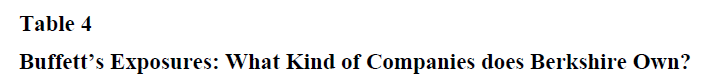

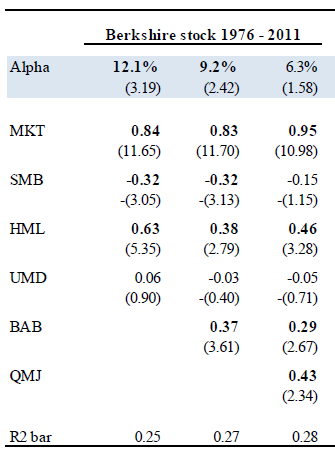

In [2]:
#hide 
display(Image("images/l1_frazzini_table4heading.PNG"))
display(Image("images/l1_frazzini_table4.PNG"))

- The characteristics of the investment of Warren Buffet: high loadings on replicable factors such as beta, size, value and quality – and a negative loading on momentum.


- At least in this replication of the paper's results (with slightly different data), the intercept is no longer statistically significant – it might still be economically significant!

In [3]:
from skfin.datasets import load_buffets_data
data = load_buffets_data(cache_dir="data").assign(excess_return=lambda x: x["BRK.A"] - x["RF"])

INFO:skfin.datasets:logging from cache directory: data/ffdata_brk13f.parquet


In [4]:
from statsmodels import api
m1 = api.OLS(data["excess_return"], api.add_constant(data["MKT"])).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           2.08e-24
Time:                        10:41:44   Log-Likelihood:                -471.71
No. Observations:                 180   AIC:                             947.4
Df Residuals:                     178   BIC:                             953.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2431      0.250      0.972      0.332      -0.251       0.737
MKT            0.6242      0.052     11.903      0.000       0.521       0.728
==============================================================================
Omnibus:                       55.501   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.454
Skew:                          -1.075   Prob(JB):                     2.50e-55
Kurtosis:                       8.377   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
summaries = []
for cols in [
    ["MKT", "SMB", "HML", "UMD"],
    ["MKT", "SMB", "HML", "UMD", "BAB"],
    ["MKT", "SMB", "HML", "UMD", "BAB", "QMJ"],
]:
    m_ = api.OLS(data["excess_return"], api.add_constant(data[cols])).fit()
    summaries += [m_.summary()]

In [6]:
def prettify_table(tbl):
    df = pd.DataFrame(tbl.tables[1].data)
    idx = df.iloc[1:, 0]
    return pd.DataFrame(
        df.iloc[1:, [1, 3]].astype(float).values,
        index=idx.rename(None),
        columns=["coef", "tstat"],
    ).stack()

In [7]:
pd.concat([prettify_table(v) for v in summaries], axis=1).fillna(0).round(2)

0      1      2
const coef    0.28   0.25   0.07
      tstat   1.32   1.21   0.33
MKT   coef    0.69   0.70   0.82
      tstat  14.41  14.31  12.31
SMB   coef   -0.32  -0.31  -0.20
      tstat  -4.28  -4.11  -2.32
HML   coef    0.49   0.45   0.46
      tstat   7.03   5.53   5.83
UMD   coef   -0.12  -0.13  -0.14
      tstat  -3.27  -3.40  -3.62
BAB   coef    0.00   0.06   0.02
      tstat   0.00   0.94   0.36
QMJ   coef    0.00   0.00   0.29
      tstat   0.00   0.00   2.61

The coefficients are qualitatively close from the results in the paper -- with the except of the `BAB` coefficients not being statistically significant.

## Industry momentum factor exposure 

In this section, we go back to the Industry momentum backtest and decompose it on the factors as computed by Ken French. 

In [8]:
returns_data = load_kf_returns(cache_dir='data')
ret = returns_data['Monthly']['Average_Value_Weighted_Returns'][:'1999']

INFO:skfin.datasets:logging from cache directory: data/12_Industry_Portfolios


In [9]:
transform_X = lambda x: x.rolling(12).mean().fillna(0).values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

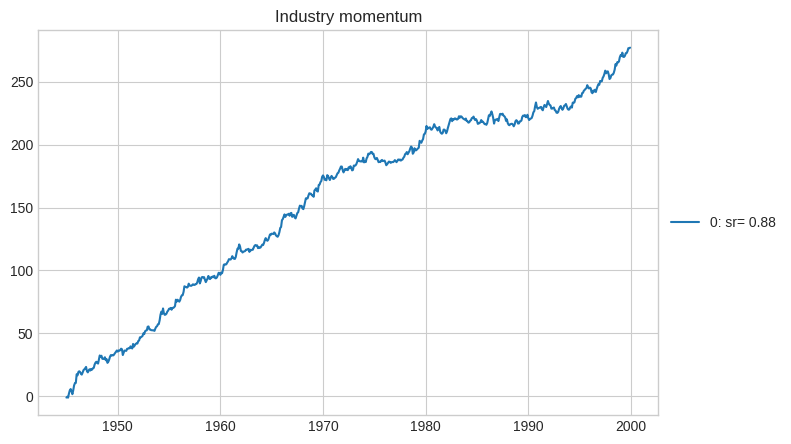

In [10]:
pnl0 = Backtester(MeanVariance(), ret).train(features, target).pnl_
line(pnl0, cumsum=True, title='Industry momentum')

In [11]:
files = ["F-F_Research_Data_Factors", "F-F_Momentum_Factor"]
df = pd.concat([load_kf_returns(c)['Monthly'] for c in files], axis=1)['1945':'1999']

INFO:skfin.datasets:logging from cache directory: /home/schamponn/dev/projects/skfin/nbs/data/F-F_Research_Data_Factors
INFO:skfin.datasets:logging from cache directory: /home/schamponn/dev/projects/skfin/nbs/data/F-F_Momentum_Factor


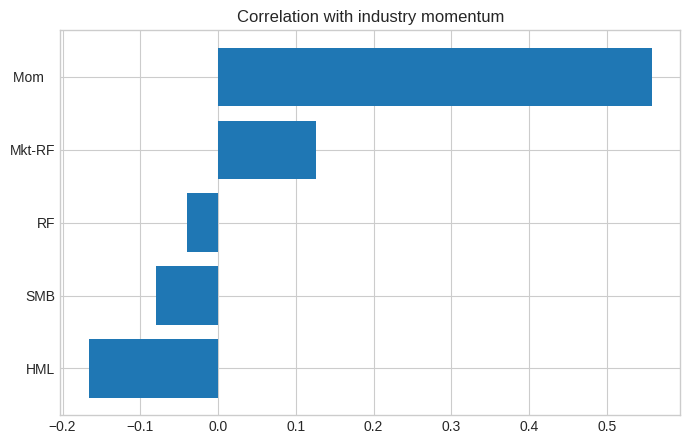

In [12]:
bar(df.corrwith(pnl0), horizontal=True, title= 'Correlation with industry momentum')

In [13]:
data = df.join(pnl0.rename('IndustryMom'))

In [14]:
m = api.OLS(data["IndustryMom"], api.add_constant(data.drop("IndustryMom", axis=1))).fit()

In [15]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IndustryMom   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     63.36
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           6.73e-54
Time:                        10:41:45   Log-Likelihood:                -1135.5
No. Observations:                 660   AIC:                             2283.
Df Residuals:                     654   BIC:                             2310.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2229      0.101      2.215      0.027       0.025       0.420
Mkt-RF         0.0374      0.014      2.763      0.006       0.011       0.064
SMB           -0.0248      0.022     -1.148      0.251      -0.067       0.018
HML           -0.0374      0.023     -1.662      0.097      -0.082       0.007
RF            -0.1849      0.212     -0.872      0.384      -0.601       0.232
Mom            0.2869      0.018     16.318      0.000       0.252       0.321
==============================================================================
Omnibus:                       19.093   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.587
Skew:                           0.212   Prob(JB):                     1.38e-07
Kurtosis:                       3.984   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

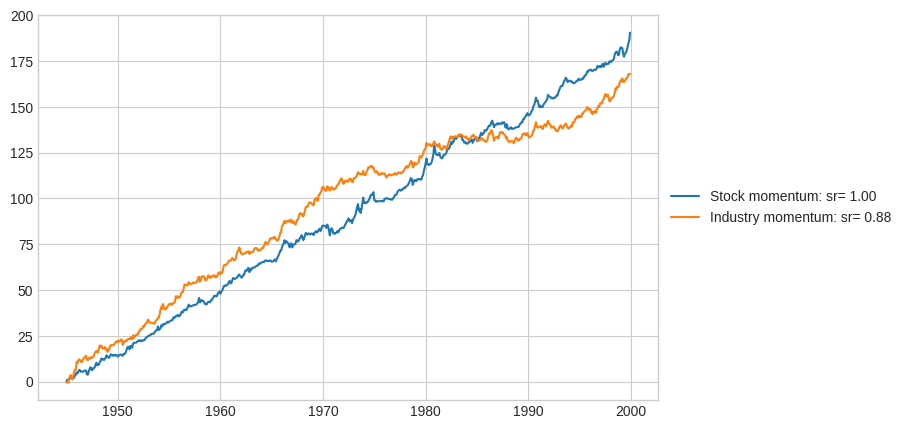

In [16]:
line(pd.concat({'Stock momentum': df['Mom   '], 
                'Industry momentum': pnl0}, axis=1).pipe(lambda x: x.div(x.std())), 
     cumsum=True)

The main issue with this statistical decomposition is that the estimation is done "full sample". In the next section, we estimate the Momentum loading on rolling windows. 

## Residual pnl 

To run the rolling estimation decomposition, we use the function `fit_predict` used in previous sections. 

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  TimeSeriesSplit
from skfin.backtesting import fit_predict

In [18]:
start_date = "1945-01-01"
max_train_size = 60
test_size = 1
params = dict(max_train_size=max_train_size, test_size=test_size, gap=0)
params["n_splits"] =  (len(data) - max_train_size) // test_size
cv_ = TimeSeriesSplit(**params)

In [19]:
pnl_hat, estimator_ = fit_predict(estimator = LinearRegression(), 
                      features = data.drop(["IndustryMom", "RF"], axis=1), 
                      target = data["IndustryMom"], 
                      ret = data["IndustryMom"].to_frame(),
                      cv = cv_, return_estimator=True)
pnl_hat = pnl_hat.squeeze()

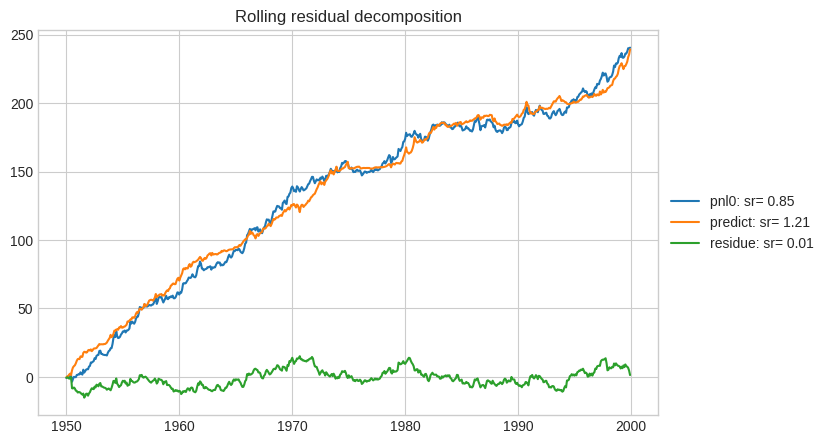

In [20]:
line({'pnl0': pnl0[max_train_size:], 'predict': pnl_hat, 
      'residue': pnl0[max_train_size:] - pnl_hat}, cumsum=True, title='Rolling residual decomposition')

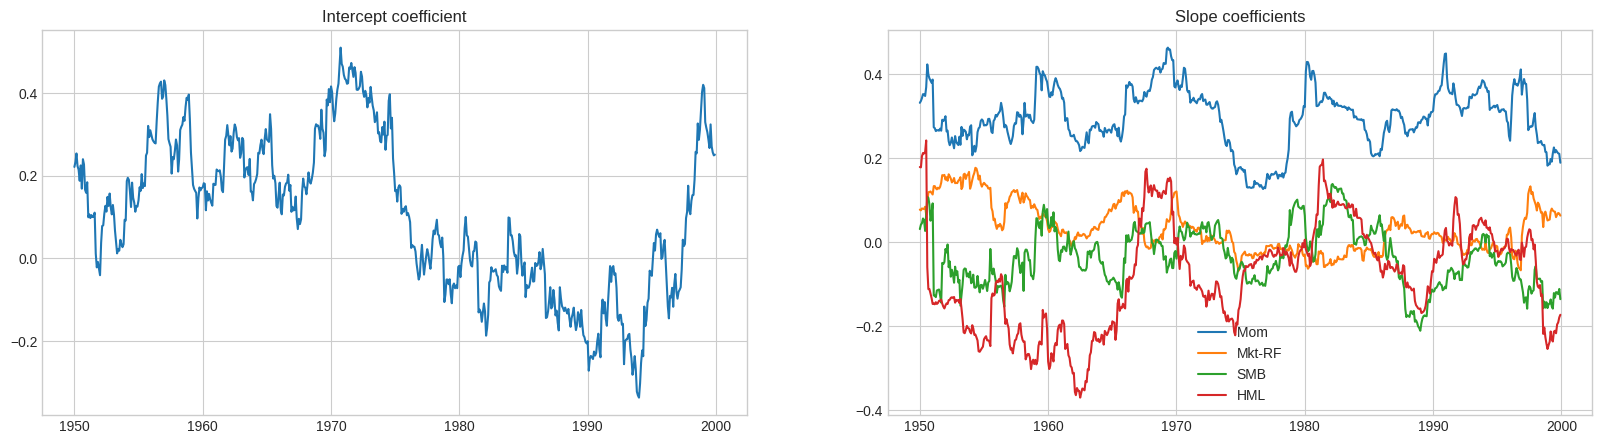

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
line(pd.DataFrame([m.intercept_ for m in estimator_], index=pnl_hat.index), 
     title='Intercept coefficient', ax=ax[0], legend=False)

line(pd.DataFrame([m.coef_ for m in estimator_], 
                  columns=data.drop(['IndustryMom', 'RF'], axis=1).columns, 
                  index=pnl_hat.index), 
     title='Slope coefficients', loc='best', ax=ax[1])

Over this period, the simple Industry momentum strategy seems to have zero residual relative to other factors. 